### **1. Imports**

In [1]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
sns.set_style('darkgrid')

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)


print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


TF version: 2.12.0
Hub version: 0.12.0
GPU is available


### **2. TL model**

In [2]:
MODULE_HANDLE= tf.keras.applications.InceptionV3(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

module_selection = ("InceptionV3", 299)
handle_base, pixels = module_selection
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))
BATCH_SIZE = 128

96112376/96112376 [==============================] - 1s 0us/step
Using <keras.engine.functional.Functional object at 0x7aa854131ea0> with input size (299, 299)


### **3. Data Preparation v1**

In [3]:
datagen_kwargs = dict(rescale=1./255)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.1,
   **datagen_kwargs)


valid_generator = valid_datagen.flow_from_directory(
    '/kaggle/input/dataset/val',
    shuffle = False,
    **dataflow_kwargs
)

do_data_augmentation = True
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2, validation_split=0.1,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen


train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/dataset/train', shuffle=True, **dataflow_kwargs)

Found 120 images belonging to 2 classes.
Found 4946 images belonging to 2 classes.


In [4]:
train_generator.class_indices

{'Normal': 0, 'OSCC': 1}

In [5]:
do_fine_tuning = True

### **4. Model Specification**

In [6]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(MODULE_HANDLE, trainable=do_fine_tuning),
    tf.keras.layers.BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    tf.keras.layers.Dense(256, kernel_regularizer= tf.keras.regularizers.l2(l= 0.016), activity_regularizer= tf.keras.regularizers.l1(0.006),
                bias_regularizer= tf.keras.regularizers.l1(0.006), activation= 'relu'),
    tf.keras.layers.Dropout(rate=0.4, seed= 42),
    tf.keras.layers.Dense(train_generator.num_classes,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                         activation= 'softmax')
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with <keras.engine.functional.Functional object at 0x7aa854131ea0>
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1000)              23851784  
                                                                 
 batch_normalization_94 (Bat  (None, 1000)             4000      
 chNormalization)                                                
                                                                 
 dense (Dense)               (None, 256)               256256    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 24,112,554
Trainable param

In [7]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
  loss= 'categorical_crossentropy',
  metrics=['accuracy'])

In [8]:
#Directory to store tensorboard data
if not os.path.exists("/kaggle/working/logs"):
    os.mkdir("/kaggle/working/logs")

In [9]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, min_delta=0.05, verbose=0)
plateau= tf.keras.callbacks.ReduceLROnPlateau(monitor= 'val_loss', factor= 0.2, patience= 4, verbose= 0, mode= 'min')
tensorboard= tf.keras.callbacks.TensorBoard(log_dir='/kaggle/working/logs', histogram_freq=0, write_graph=True, write_images=False, write_steps_per_second=False, update_freq='epoch', profile_batch=0, embeddings_freq=0, embeddings_metadata=None)

steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size

### **5. Training the model**

In [10]:
hist = model.fit(
    train_generator,
    epochs=100,
    verbose= 1,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps,
    callbacks=[early_stopping, plateau, tensorboard],
    shuffle= False
)

Epoch 1/100
38/38 [==============================] - 347s 7s/step - loss: 3.5782 - accuracy: 0.7615 - lr: 0.0010
Epoch 2/100
38/38 [==============================] - 198s 5s/step - loss: 0.6673 - accuracy: 0.8851 - lr: 0.0010
Epoch 3/100
38/38 [==============================] - 196s 5s/step - loss: 0.3296 - accuracy: 0.8954 - lr: 0.0010
Epoch 4/100
38/38 [==============================] - 196s 5s/step - loss: 0.2697 - accuracy: 0.9134 - lr: 0.0010
Epoch 5/100
38/38 [==============================] - 197s 5s/step - loss: 0.2315 - accuracy: 0.9359 - lr: 0.0010
Epoch 6/100
38/38 [==============================] - 196s 5s/step - loss: 0.2086 - accuracy: 0.9443 - lr: 0.0010
Epoch 7/100
38/38 [==============================] - 194s 5s/step - loss: 0.1837 - accuracy: 0.9544 - lr: 0.0010
Epoch 8/100
38/38 [==============================] - 194s 5s/step - loss: 0.1845 - accuracy: 0.9515 - lr: 0.0010
Epoch 9/100
38/38 [==============================] - 193s 5s/step - loss: 0.1820 - accuracy: 0.9

### **6. Testing the model**

In [11]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
   **datagen_kwargs)

test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/dataset/test',
    shuffle = False,
    **dataflow_kwargs
)

preds = model.evaluate(test_generator)
preds = (model.predict(test_generator) > 0.5).astype("int32")

Found 126 images belonging to 2 classes.
1/1 [==============================] - 10s 10s/step


### **7. Plotting accuracy and loss graph, confusion matrix, ROC curve**

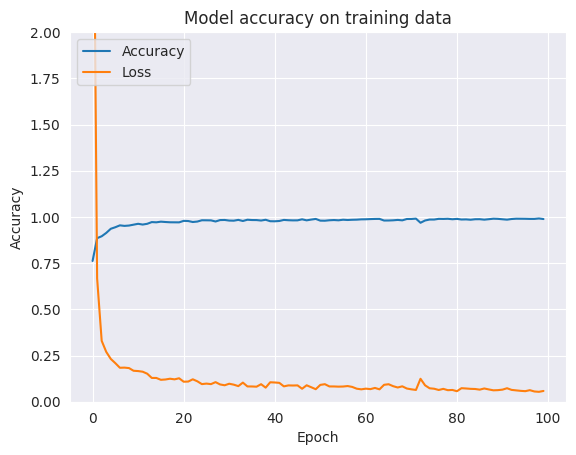

In [12]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['loss'])
plt.title('Model accuracy on training data')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0, 2])
plt.legend(['Accuracy', 'Loss'], loc='upper left')
plt.show()

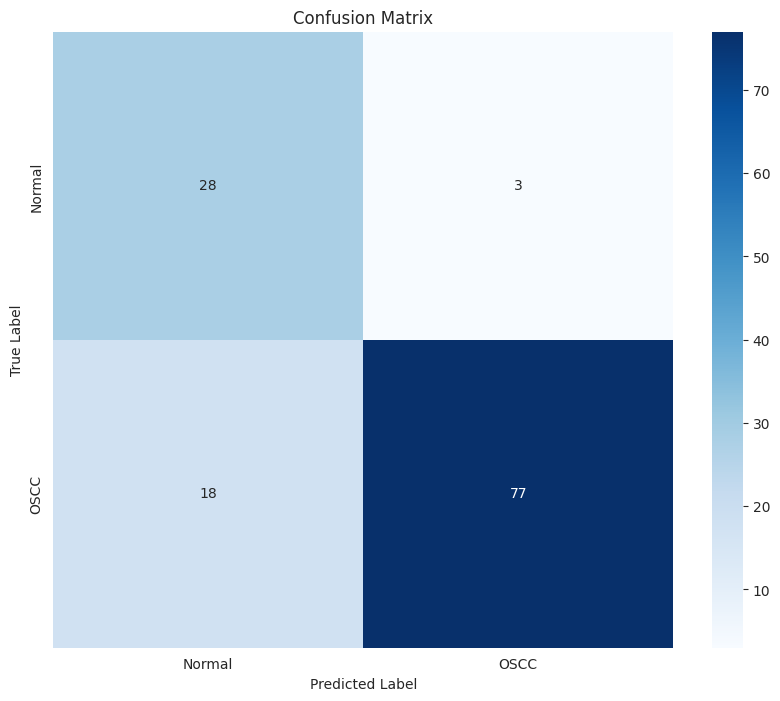

              precision    recall  f1-score   support

      Normal       0.61      0.90      0.73        31
        OSCC       0.96      0.81      0.88        95

    accuracy                           0.83       126
   macro avg       0.79      0.86      0.80       126
weighted avg       0.88      0.83      0.84       126



In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_true_labels = test_generator.classes
y_pred_labels = np.argmax(preds, axis=1)

class_names = list(test_generator.class_indices.keys())

confusion_mtx = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, cmap="Blues", annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Classification report
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))


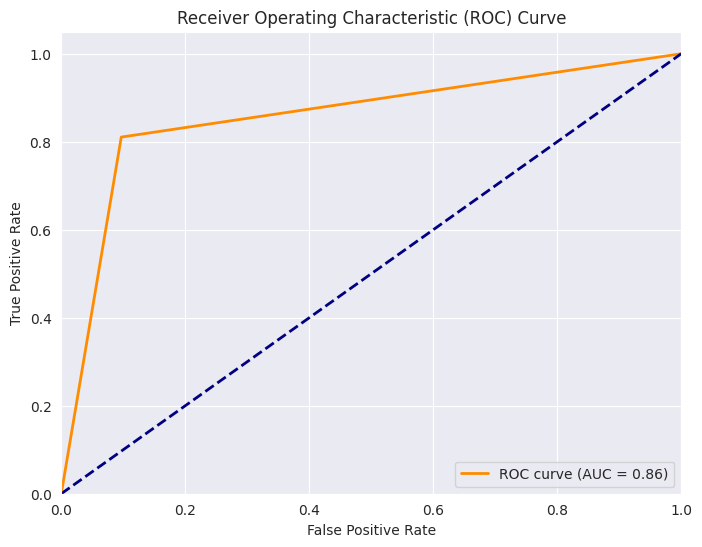

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming you have your true labels in 'y_true' and predicted probabilities in 'y_pred_probs'

# Define a function to calculate the ROC curve
def plot_roc_curve(fpr, tpr):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_true_labels, y_pred_labels)

# Plot the ROC curve
plot_roc_curve(fpr, tpr)


### **8. Saving the model**

In [15]:
# serialize model to JSON

# serialize weights to HDF5
model.save_weights("InceptionV3.h5")

In [26]:
saved_model_path = "/kaggle/working"

# Save the model in the SavedModel format
tf.saved_model.save(model, saved_model_path)
